# Investigating Fandango Movie Ratings

This project is developed based on the guided project on dataquest.io. The goal of the project is to analyze recent movie ratings data from fandango to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

### Background: Hickey's Analysis
Source - [Dataquest](http://dataquest.io/)

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

* The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
* In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
* For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

<img src='actual_vs_displayed.png'>

The two distributions above are displayed using a simple line plot, which is also a valid way to show the shape of a distribution. The variable being examined is movie rating, and for each unique rating we can see its relative frequency (percentage) on the y-axis of the graph. When an analysis report is intended for large audiences, relative frequencies (especially percentages) are preferred over absolute frequencies.

Both distributions above are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high. We can see there's no rating under 2 stars in the sample Hickey analyzed. The distribution of displayed ratings is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

Dataquest has provided their own version of the [potential solution](https://github.com/dataquestio/solutions/blob/master/Mission288Solutions.ipynb) for this task.

## Understanding the Data

To figure out whether there has been any changes to Fandango's rating system after Hickey's analysis, we can compare the data previous to the analysis and data after the analysis.

* Walt Hickey made the data he analyzed publicly available [on GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.

* One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available [on GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

Each of the above repositories contain the description of columns in those datasets.

We will first load these files and explore the contents to familiarise with the dataset.

In [1]:
import pandas as pd

# source names
source_before = "fandango_score_comparison.csv"
source_after = "movie_ratings_16_17.csv"

# load dataframes
fandango_prev = pd.read_csv(source_before)
fandango_after = pd.read_csv(source_after)

fandango_prev.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [2]:
fandango_after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


From the above, we can see that we don't need all of the variables for our analysis. Let's pin down the features we need. We will use `copy` in order to avoid the issue with `SettingWithCopyWarning`. The issue is that when we subset we work on a view of the dataframe instead of a separate dataframe. For more information, you can read [here](https://www.dataquest.io/blog/settingwithcopywarning/)

In [3]:
# isolating columns we are interested in
cols_prev = ['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']
cols_after = ['movie', 'year', 'fandango']

# subset columns
fandango_prev = fandango_prev[cols_prev].copy()
fandango_after = fandango_after[cols_after].copy()

# check
fandango_prev.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


Based on the above sources and the actual analysis, it can be seen the population of our interest are all the movies that have been rated by an audience on the Fandango website. Now, both of our datasets contains slightly different criteria for including the movies into the dataset

* Data collected by Hickey contains every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango, as well as the movies that had tickets on sale in 2015
* Data collected by Alex from dataquest contains movie ratings data for 214 of the most popular movies (with a significant number of votes) released in 2016 and 2017 also from the same sources.

We can say that both samples are not randomly sampled in the sense that only movies that are popular (at least 30 fan reviews and most popular) were included. This means that our sample is not representative of the larger population. Both of the samples seem to be subject to temporal trends and have a bias in choosing the samples. The sampling method used here by both Hickey and Alex is [purposive sampling](https://www.youtube.com/watch?v=CdK7N_kTzHI&feature=youtu.be), under which the researcher uses their own judgment to choose a sample from the population of interest.

For our analysis these samples might not be very useful, while they were relevant for the respective authors' researches.

### Moving Forward

We have come to stopping point in our analysis. Since the samples are not representative they might not help us answer our research question. In this situation we have two potential options:

* Collect new data that is more representative of the population
* Change the goal of our analysis, by introducing limitations

#### Our New Goal

In order to be able to use the datasets above as representative of our population, we need to change our goal of the analysis. The previous goal was 'To determine whether there has been any change in Fandango's rating system after Hickey's analysis'. The new goal would make the datasets we have representative of the population. We can achieve this by changing it to the new goal which would be 'To determine whether there has been any change in Fandango's rating system of popular movies in 2015 and Fandango's ratings in 2016'.

#### Determining the samples

In order to tackle our new goal of the analysis, we need to use the following data:

* All Fandango's ratings for popular movies released in 2015
* All Fandango's ratings for popular movies released in 2016

To clarify the notion of 'popular' we will use the 30 ratings or above as a criteria identifying popular movies. Next, let's check each of our samples whether they contain data according to our sampling criteria. Despite that, we can observe the first sample dataset fan ratings column, which we can use in order to filter the data, but the second sample doesn't. The second dataset is a bit challenging since we don't have information about fan ratings (number of votes) per movie. This is an issue since it poses a question of whether this sample is truly representative. One quick way to deal with this is to randomly sample from that sample and then manually check the number of votes on the website.

In [4]:
# randomly sample 10 movies from our 2nd sample from only 2016
fandango_after.sample(10, random_state=11)

,movie,year,fandango
130,Patriots Day,2016,4.5
186,The Light Between Oceans,2016,4.0
69,Hidden Figures,2016,5.0
165,The Brothers Grimsby,2016,3.5
178,The Girl with All the Gifts,2016,4.0
159,The Accountant,2016,4.5
63,Gods of Egypt,2016,3.5
33,Cell,2016,3.0
199,The Wild Life,2016,3.0
3,A Dog's Purpose,2017,4.5


The data for fandango ratings was collected in May 2019. We can see that all samples are from 2016 Here are the ratings below:

| Movie | Fan Ratings |
|-------|-------------|
| Patriots Day | 2313 |
| The Light Between Oceans | 1284 |
| Hidden Figures | 11800 |
| The Brothers Grimsby | 988 |
| The Girl with All the Gifts | 19 |
| The Accountant | 10237 |
| Gods of Egypt | 2543 |
| Cell | 18 |
| The Wild Life | 459 |
| A Dog's Purpose | 3393 |

More than 80% of our dataset is above 30 ratings so we can proceed with confidence that this sample is representative.

Next, we will filter the records from our sample datasets according to our criteria of 2015 and 2016 with more than 30 ratings. Before that our first sample doesn't have a year column and the year is in the `FILM` column. We will extract it first.

In [5]:
# extract year from fandango prev
fandango_prev['year'] = fandango_prev['FILM'].str[-5:-1].astype(int)

# check the year distribution of each sample
print(fandango_prev['year'].value_counts())
print(fandango_after['year'].value_counts())

2015    129
2014     17
Name: year, dtype: int64
2016    191
2017     23
Name: year, dtype: int64


We can see both samples contain movies from two year. We will filter out only the movies we need from both samples.

In [6]:
# check for movies in 2015 and 2016 with more than 30 fan ratings
fandango_2015 = fandango_prev[(fandango_prev['year'] == 2015) & (fandango_prev['Fandango_votes'] > 30)].copy()

# filter the data
fandango_2016 = fandango_after[(fandango_after['year'] == 2016)].copy()

We have isolated datasets for 2015 and 2016 fitting our criteria. In the next section, we will use these datasets to perform our analysis.

# Comparing Distribution Shapes for 2015 and 2016

Once again, our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

First, let's generate kernel density plots of movie ratings of each sample.

In [7]:
import matplotlib.pyplot as plt

# change style to fivethirtyeight style
plt.style.use('fivethirtyeight')

# plot density plots
fandango_2015['Fandango_Stars'].plot.kde(label='2015', legend=True, figsize=(10, 8))
fandango_2016['fandango'].plot.kde(label='2016', legend=True)

xrange = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
plt.xticks(xrange)
plt.xlim([0, 5])
plt.xlabel("Stars")
plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)", y=1.05)
plt.show()

<Figure size 1000x800 with 1 Axes>

We can see from the above plots two major observations:
* Ratings from both years are left skewed
* Ratings from 2015 are slightly skewed to the right compared to 2016

The distribution from 2015 seem to have more values around 4 stars and 2016 around 4.5. Left skewedness of both distributions indicate higher movie ratings for both years, but 2016 ratings are skewed to the left more than 2016. This is evidence that ratings f
rom 2016 are slightly less than that of 2016, which suggests that there was a change in the ratings from 2015 and 2016. We need to analyse this in more detail.

# Comparing Relative Frequencies

In this section we will compare the relative frequencies of each distribution. We could compare absolute frequencies, but it would not help much. We will use relative frequency percentages.

In [8]:
print('2015\n--------')
fandango_2015['Fandango_Stars'].value_counts(normalize=True) * 100

2015
--------


4.5    37.984496
4.0    28.682171
3.5    17.829457
3.0     8.527132
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [9]:
print('2016\n--------')
fandango_2016['fandango'].value_counts(normalize=True) * 100

2016
--------


4.0    40.314136
4.5    24.607330
3.5    24.083770
3.0     7.329843
2.5     3.141361
5.0     0.523560
Name: fandango, dtype: float64

While usually it might be slightly difficult to tell from the tables the direction of the difference between years, here we can see that in 2016 there has been more ratings of 4 stars approx 40% which is 12% more than 2015. In both cases most of the ratings were 4 and 4.5, indicating that overall the ratings are usually high for both years. Nevertheless, in 2016 less than 1% of movies had rating of 5 stars while in 2015 this was about 7%. We will use this information to try to determine the direction of change.

# Determining the direction of Change

In this section we will use statistical metrics such mean, mode and median to understand the direction of Change in our sample. Based on this we will make inferences about our population and ultimately answer our analysis question. 

In [10]:
# 2015 stats
stats15 = fandango_2015['Fandango_Stars'].agg(['mean', 'median'])
mean15 = stats15[0]
median15 = stats15[1]
mode15 = fandango_2015['Fandango_Stars'].mode()[0]
print('2015\n-----\nMode:', mode15)
print('Mean:', mean15)
print('Median:', median15, '\n')

# 2016 stats
stats16 = fandango_2016['fandango'].agg(['mean', 'median'])
mean16 = stats16[0]
median16 = stats16[1]
mode16 = fandango_2016['fandango'].mode()[0]
print('2016\n-----\nMode:', mode16)
print('Mean:', mean16)
print('Median:', median16)

2015
-----
Mode: 4.5
Mean: 4.0852713178294575
Median: 4.0 

2016
-----
Mode: 4.0
Mean: 3.887434554973822
Median: 4.0


From the summary above, we can see that average rating has dropped from 2015 to 2016 with mode also dropping from 4.5 as the common value to 4.0. Both these indicators tell us that there was a change in ratings between these years in 2016 with lower ratings than 2015.

We can use grouped bar plot to compare the statistic values to determine the direction of change visually as well.

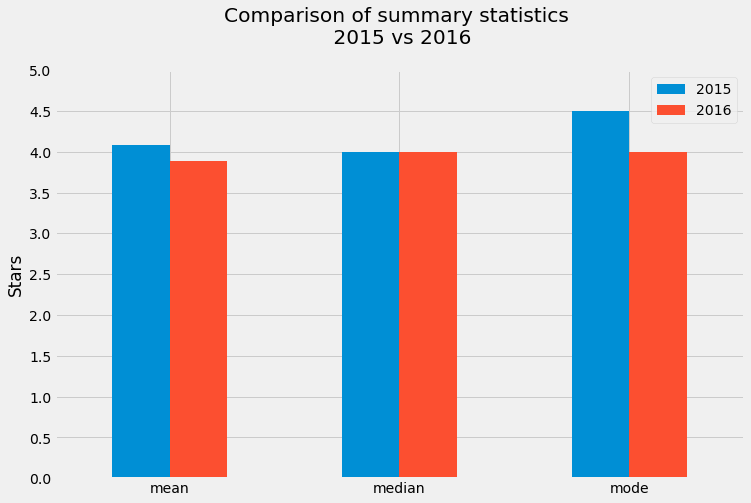

In [11]:
# organize results into dataframe
results = pd.DataFrame(index=['mean', 'median', 'mode'])
results['2015'] = [mean15, median15, mode15]
results['2016'] = [mean16, median16, mode16]

# make a grouped bar plot
plt.style.use('fivethirtyeight')
results.plot(kind='bar', figsize=(11, 7))
plt.title("Comparison of summary statistics \n 2015 vs 2016", y=1.05)
plt.ylabel("Stars")
plt.xticks(rotation=0)
plt.yticks(xrange)
plt.show()

In [12]:
drop = (results.loc['mean'][0] - results.loc['mean'][1]) / results.loc['mean'][0]
print("The drop was {0:.0%}".format(drop))

The drop was 5%


Visually its also seen that there was a drop in mean and mode ratings from 2015 and 2016. Also the drop in average was almost 5% (rounded).

# Conclusion

We can conclude that the ratings in 2016 have dropped compared to 2015. We can observe that the average rating dropped 5% while the common value (mode) has also dropped from 4.5 to 4. We saw that on average the popular movies were rated lower in 2016 than in 2015. While we can't pinpoint the cause of this, its more likely that the website have fixed their rating system on the website.